# NLTP Data Analysis and Cleaning with IMDB Movie Reviews Dataset

Subject: Data Aalysis and Data Cleaning/Preprocessing plus simple sentiment Analysis LSMT Model

Dataset: IMDB Movie Reviews (via Kaggle) containing 50.000 user reviews for movies and  label for each, 'negative' or 'positive'.

Data Analysis:
- Visualize Balanced of Labels with pandas/plt value_counts() plot
- Visualize distribution of number of words per label with sns.histplot()
- Visualize quotas of stopwords with sns.histplot()
- Visualize most frequent words with wordcloud.WordCloud() and sns.barplot()
- Apply n-gram (bigram and trigram) analysis and visualize most frequent n_grams with plotly.offline.iplot

Preprocessing:
- train/test-split with sklearn.model_selection.train_test_split
- remove HTML Tags with RegEx
- remove URLs with RegEx
- remove Emojis with RegEx (not executed)
- replace contractions like "he's" -> "he is" with static contractions mapping
- lemmatize with nltk.pos_tag (for getting part-of-speech per word), nltk.corpus.wordnet, and nltk.stem.WordNetLemmatizer for lemmatizing (not executed)
- load pretrained embeddings (google-news-300 word2vec) and detect missing words
- remove double quotes (required after some tokenizing steps)
- remove stopwords with nltk.corpus.stopwords
- remove punctuation with RegEx
- remove numbers with RegEx
- Americanize British words so as to fit embeddings with mapping downloaded from https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json
- Tokenize with nltk.tokenize.word_tokenize()
- Token2index
- Tensorize

Build Sentiment Analysis Model:
- Adopt pretrained embeddings for relevant words, initially-zero embeddings for words not in pretrained embeddings
- Create classifier with nn.module, nn.Embedding (prefilled, see above), nn.LSTM, nn.Linear, nn.Softmax
- Train model on training data with nn.CrossEntropyLoss and torch.optim.Adam as optimizer
- Evaluate by computing accuracy on training and test data

Others:
- compatible with Colab for saving/loading files from Google Drive
- CUDA support

Sources:
- https://www.kaggle.com/code/colearninglounge/nlp-data-preprocessing-and-cleaning/notebook?scriptVersionId=48903343
- https://www.kaggle.com/code/tientd95/deep-learning-for-sentiment-analysis



In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

if IN_COLAB := 'google.colab' in str(get_ipython()):
    !pip install torchviz
    !pip install portalocker
    BASE_PATH = './drive/MyDrive/Colab/'
    from google.colab import drive
    drive.mount('/content/drive')

    import nltk
    nltk.download('wordnet')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')

else:
    BASE_PATH = '../'

Running on cuda
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=281516a89921162799f169d0e31f24908266e826a9c0370241de26a30996eefb
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from pprint import pprint

import torchtext
import pandas as pd

import locale
locale.setlocale(locale.LC_ALL, locale='')  # for thousands separator via ... print(f'{value:n}')"

'en_US.UTF-8'

## Data Analysis

In [3]:
import string
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import plotly.graph_objs as go
import plotly
from plotly.subplots import make_subplots

In [4]:
# note torch imdb dataset seems defect,
# torchtext.datasets.IMDB(root=BASE_PATH, split='train')
# we therefore use local file
df_imdb = pd.read_csv(BASE_PATH + 'data/imdb/IMDB Dataset.csv')
df_imdb









# todoooooooooo train test split

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Balance

positive    25000
negative    25000
Name: sentiment, dtype: int64


<Axes: >

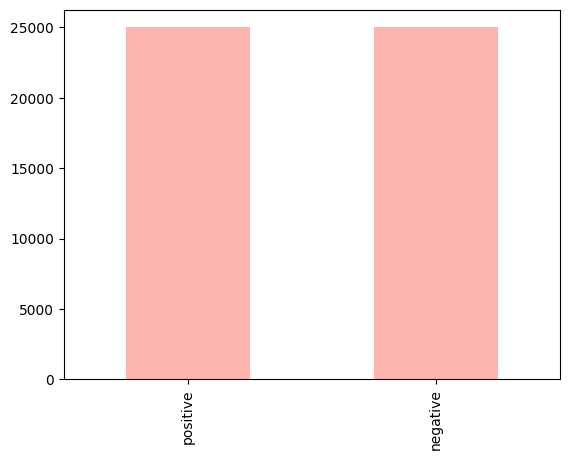

In [5]:
# we have a balanced dataset
# 1 is negative
# 0 is positive
print(df_imdb['sentiment'].value_counts())
df_imdb['sentiment'].value_counts().plot(kind='bar', colormap='Pastel1')

### Words Count

In [6]:
def plot_counts(counts_positive: pd.Series,
                counts_negative: pd.Series,
                label_x: str,
                title: str):
    fig,(ax1,ax2)=plt.subplots(1,
                               2,
                               figsize=(15,5))
    positive_histplot = sns.histplot(counts_positive,
                 ax=ax1,
                 color="blue")
    positive_histplot.set(xlabel = label_x,
                          ylabel = "Count Reviews",
                          title='Positive Reviews')
    negative_histplot = sns.histplot(counts_negative,
                                     ax=ax2,
                                     color="red")
    negative_histplot.set(xlabel = label_x,
                          ylabel = "Count Reviews",
                          title='Negative Reviews')
    fig.suptitle(title)
    plt.show()

In [7]:
df_positive = df_imdb[df_imdb['sentiment'] == 'positive']
df_negative = df_imdb[df_imdb['sentiment'] == 'negative']

counts_positive = df_positive['review'].str.split().apply(lambda z:len(z))
counts_negative = df_negative['review'].str.split().apply(lambda z:len(z))

print(counts_positive)

0        307
1        162
2        166
4        230
5        119
        ... 
49983    133
49985    216
49989    173
49992    170
49995    194
Name: review, Length: 25000, dtype: int64


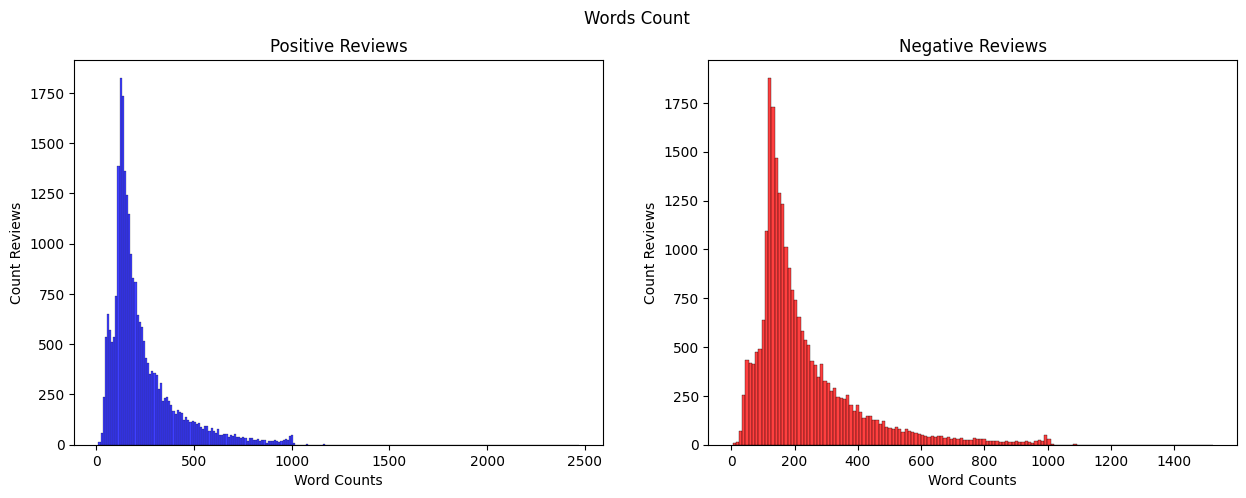

Average number of words in positive reviews: 232.85
Average number of words in negative reviews: 229.46


In [8]:
plot_counts(counts_positive,
            counts_negative,
            label_x="Word Counts",
            title="Words Count")

print(f'Average number of words in positive reviews: {float(counts_positive.mean()) :5.2f}')
print(f'Average number of words in negative reviews: {float(counts_negative.mean()) :5.2f}')

### Punctuations

In [9]:
punctuation = string.punctuation + '“”’…'
pprint(punctuation)

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’…'


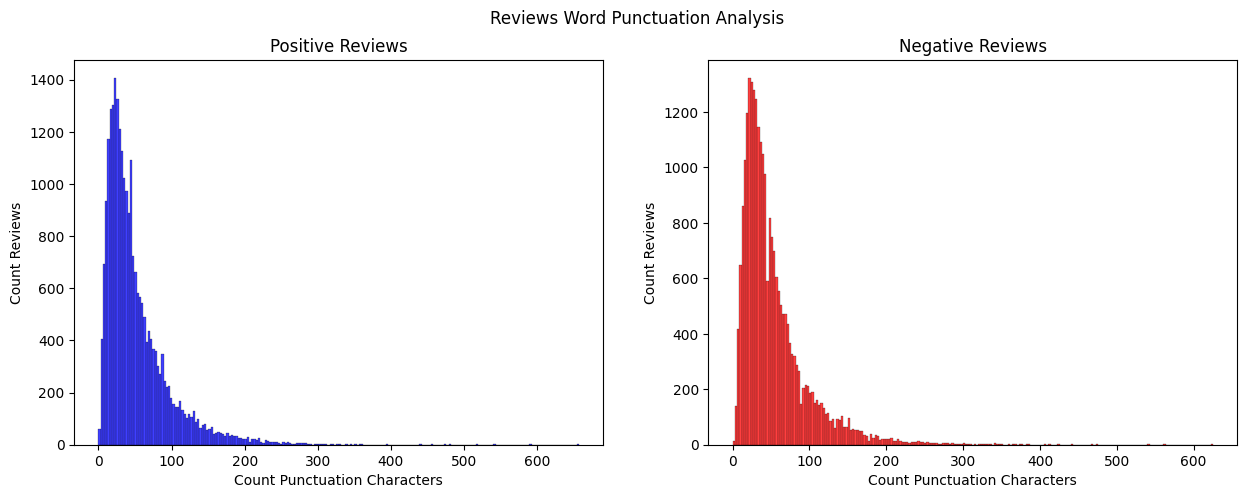

Average number of punctuation characters in positive reviews: 51.57
Average number of punctuation characters in negative reviews: 53.61


In [10]:
counts_punct_positive = df_positive['review'].apply(lambda z: len([c for c in z if c in punctuation]))
counts_punct_negative = df_negative['review'].apply(lambda z:len([c for c in z if c in punctuation]))

plot_counts(counts_punct_positive,
            counts_punct_negative,
            label_x="Count Punctuation Characters",
            title="Reviews Word Punctuation Analysis")

print(f'Average number of punctuation characters in positive reviews: {float(counts_punct_positive.mean()) :5.2f}')
print(f'Average number of punctuation characters in negative reviews: {float(counts_punct_negative.mean()) :5.2f}')

### Stopwords (most common words)

In [11]:
stop_words = set(stopwords.words('english'))
pprint(list(stop_words)[:20])

['doing',
 "wasn't",
 'won',
 'did',
 'until',
 'above',
 "didn't",
 'whom',
 'in',
 'most',
 'no',
 'my',
 'to',
 'them',
 "mustn't",
 'yourselves',
 'mustn',
 'while',
 "that'll",
 'it']


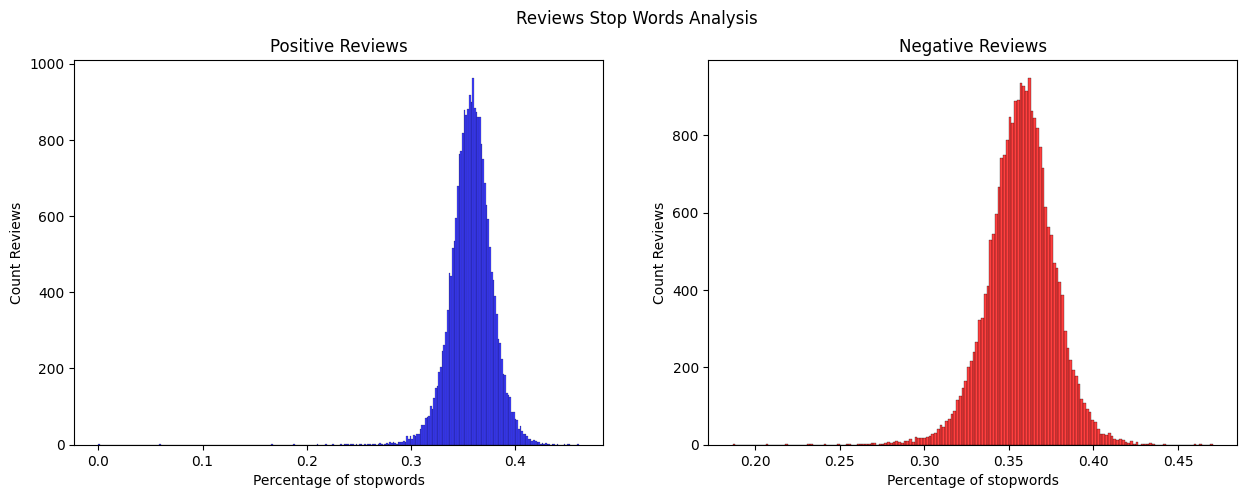

Average percentage of stopwords characters in positive reviews: 35.82%
Average percentage of stopwords characters in negative reviews: 35.72%


In [12]:
share_stop_positive = df_positive['review'].apply(lambda words:len([w for w in words if w in stop_words])/len(words))
share_stop_negative = df_negative['review'].apply(lambda words:len([w for w in words if w in stop_words])/len(words))

plot_counts(share_stop_positive,
            share_stop_negative,
            label_x="Percentage of stopwords",
            title="Reviews Stop Words Analysis")

print(f'Average percentage of stopwords characters in positive reviews: {float(share_stop_positive.mean()) :.2%}')
print(f'Average percentage of stopwords characters in negative reviews: {float(share_stop_negative.mean()) :.2%}')

### Wordcloud

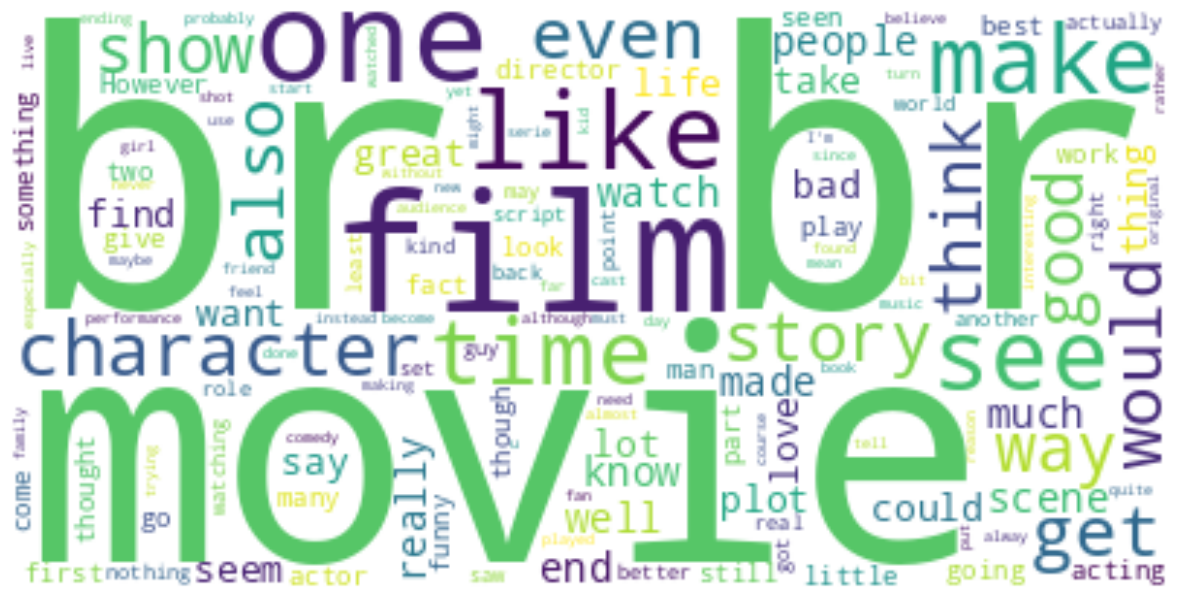

In [13]:
# wordcloud.WordCloud Visualization

def display_cloud(ser: pd.Series):
    plt.subplots(figsize=(15,10))
    wc = WordCloud(stopwords=stop_words,
                   background_color="white",
                   max_words=2000,
                   max_font_size=256,
                   random_state=42,
                  )
    wc.generate(' '.join(ser))
    plt.imshow(wc,
               interpolation="bilinear")
    plt.axis('off')
    plt.show()

display_cloud(df_imdb['review'])

In [14]:
corpus_positive = [word for tokenized_review in df_positive['review'].str.split() for word in tokenized_review if word not in stop_words]
corpus_negative = [word for tokenized_review in df_negative['review'].str.split() for word in tokenized_review if word not in stop_words]

print(f'The {len(df_positive)} positive review have a total of {len(corpus_positive)} words (excluding stopwords).')
print(f'The {len(df_negative)} negative review have a total of {len(corpus_negative)} words (excluding stopwords).')

The 25000 positive review have a total of 3432748 words (excluding stopwords).
The 25000 negative review have a total of 3386660 words (excluding stopwords).


In [15]:
# wordclouds look good, but a simple list of the most frequent words would be better...
counter_positive = Counter(corpus_positive)
counter_negative = Counter(corpus_negative)

In [16]:
# for the barplot we need a list of words and a list of the words' counts
most_common_positive: list[tuple[str, int]] = counter_positive.most_common(30)
most_common_negative: list[tuple[str, int]] = counter_negative.most_common(30)

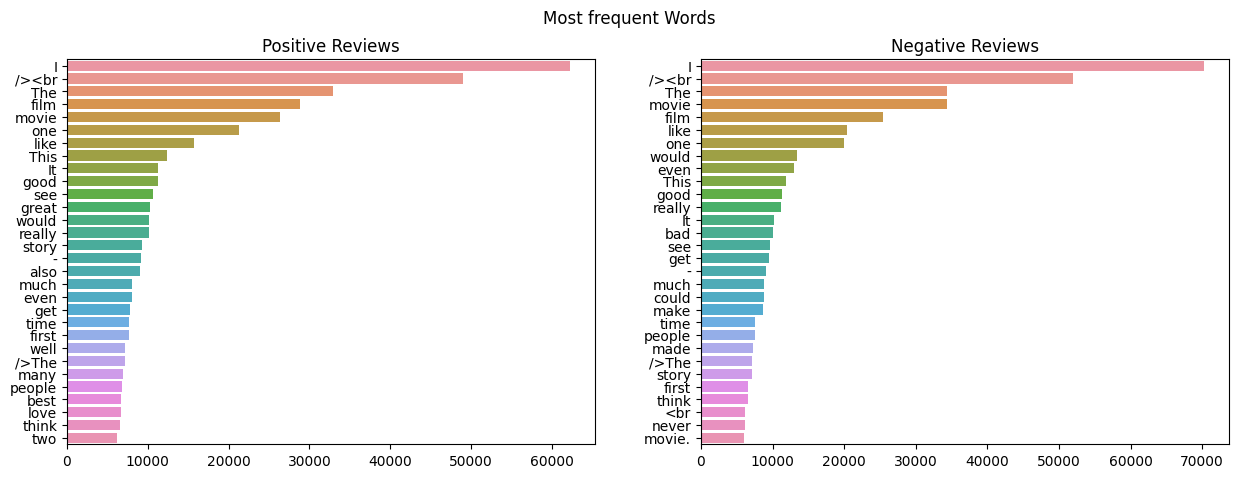

In [17]:
fig,(ax1,ax2)=plt.subplots(1,
                           2,
                           figsize=(15,5))
positive_plot = sns.barplot(x=[count for _, count in most_common_positive],
                            y=[word for word, _ in most_common_positive],
                            ax=ax1)
positive_plot.set(title='Positive Reviews')
negative_plot = sns.barplot(x=[count for _, count in most_common_negative],
                            y=[word for word, _ in most_common_negative],
                            ax=ax2)
negative_plot.set(title='Negative Reviews')
fig.suptitle('Most frequent Words')
plt.show()

### Conclusions so far

- dataset is balanced.
- dataset contains redundant words and some html syntax.
- words count, punctuations, and stopwords are present in equal distribution for both positive and negative reviews.

### n-gram analysis

In [18]:
def gram_analysis(review: str,
                  n_gram: int) -> list[str]:  # returns a list of strings, each containing n_gram word tokens (stopwords ignored)
    tokens=[t for t in review.lower().split(" ") if t!="" if t not in stop_words]
    ngrams=zip(*[tokens[i:] for i in range(n_gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

# Example:
# gram_analysis(review='Why can\'t a movie be rated a zero? Or even a negative number? Some movie rated 1 is so bad they\'re fun to watch.',
#               n_gram=2)
# --> ["can't movie", 'movie rated', 'rated zero?', 'zero? even', 'even negative', 'negative number?', 'number? movie', 'movie rated', 'rated 1', '1 bad', "bad they're", "they're fun", 'fun watch.']

In [19]:
#Create frequency grams for analysis
def create_dict(ser_reviews: pd.Series,
                n_gram: int) -> defaultdict[int]:
    frequency_dict = defaultdict(int)
    for sentence in ser_reviews:
        for tokens in gram_analysis(sentence, n_gram):
            frequency_dict[tokens]+=1
    return frequency_dict

# Example:
# ser = pd.Series(['Why can\'t a movie be rated a zero? Or even a negative number?',
#                  'Some movie rated 1 is so bad they\'re fun to watch.'])
# create_dict(ser, n_gram=2)
# --> defaultdict(<class 'int'>, {"can't movie": 1, 'movie rated': 2, 'rated zero?': 1, 'zero? even': 1, 'even negative': 1, 'negative number?': 1, 'rated 1': 1, '1 bad': 1, "bad they're": 1, "they're fun": 1, 'fun watch.': 1})

In [20]:
def create_barchart_for_frequence_dict(frequency_dict: dict[str, int]) -> go.Bar:
    # convert dict (gram to count) to list of tuples (gram, count) in descending order by count
    sorted_n_grams = sorted(frequency_dict.items(),
                            key=lambda z:z[1],
                            reverse=True)
    sorted_n_grams = sorted_n_grams[:25]
    sorted_n_grams.reverse()  # reverse for the barplot
    # create plotly barchart
    barchart = go.Bar(
        y=[b[0] for b in sorted_n_grams],
        x=[b[1] for b in sorted_n_grams],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color='orange',
        ),
    )
    return barchart

In [21]:
def plot_barcharts(barchart_negative: go.Bar,
                   barchart_positive: go.Bar,
                   subject: str):  # 'bigrams', 'trigrams'...
    fig = make_subplots(rows=1,
                        cols=2,
                        vertical_spacing=0.04,
                        subplot_titles=[f"Frequent {subject} in negative reviews",
                                        f"Frequent {subject} in positive reviews"])
    fig.append_trace(barchart_negative, 1, 1)
    fig.append_trace(barchart_positive, 1, 2)
    fig['layout'].update(height=1200,
                         width=900,
                         paper_bgcolor='rgb(233,233,233)',
                         title=f"{subject} Plots")
    plotly.offline.iplot(fig, filename=f'{subject}-plots')

In [22]:
ser_negative = df_negative['review']
ser_positive = df_positive['review']

In [23]:
bigram_frequency_negative = create_dict(ser_negative,
                                        n_gram=2)
bigram_frequency_positive = create_dict(ser_positive,
                                        n_gram=2)

print(f'Found a total of {len(bigram_frequency_negative) :n} distinct bigrams in negative reviews.')
print(f'Found a total of {len(bigram_frequency_positive) :n} distinct bigrams in positive reviews.')

Found a total of 2,097,310 distinct bigrams in negative reviews.
Found a total of 2,208,317 distinct bigrams in positive reviews.


In [24]:
barplot_negative = create_barchart_for_frequence_dict(bigram_frequency_negative)
barplot_positive = create_barchart_for_frequence_dict(bigram_frequency_positive)

plot_barcharts(barplot_negative, barplot_positive, 'bigrams')

In [25]:
trigram_frequency_negative = create_dict(ser_negative,
                                        n_gram=3)
trigram_frequency_positive = create_dict(ser_positive,
                                        n_gram=3)

print(f'Found a total of {len(trigram_frequency_negative) :n} distinct trigrams in negative reviews.')
print(f'Found a total of {len(trigram_frequency_positive) :n} distinct trigrams in positive reviews.')

barplot_negative = create_barchart_for_frequence_dict(trigram_frequency_negative)
barplot_positive = create_barchart_for_frequence_dict(trigram_frequency_positive)

plot_barcharts(barplot_negative, barplot_positive, 'trigrams')

Found a total of 2,923,656 distinct trigrams in negative reviews.
Found a total of 3,021,929 distinct trigrams in positive reviews.


## Train/Test Split

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df_train, df_test = train_test_split(df_imdb,
                               test_size=0.2)
print(df_train.shape)
print(df_test.shape)

(40000, 2)
(10000, 2)


## Cleaning

In [28]:
import re

### Remove Html Tags
We remove HTML tags before punctuation

In [98]:
html_tag = re.compile(r'<.*?>')

def remove_html(review: str):
    # note: we don't simply remove tags but replace them with space as otherwise things could occure
    # like ...done.I have... with no dot in-between sentences
    review = html_tag.sub(r' ', review)
    return review


# in case that we added too many spaces, remove them
whitespaces = re.compile(r'\s{2,}')

def remove_duplice_whitespace(review: str):
    review = whitespaces.sub(r' ', review)
    return review

In [ ]:
cleansed = df_train['review'].apply(lambda z: remove_html(z))
cleansed = cleansed.apply(lambda z: remove_duplice_whitespace(z))

### Remove URLs

In [105]:
url_re = re.compile(r"https://\S+|www\.\S+")

def remove_url(review: str):
    review = url_re.sub(r'', review)
    return review

In [ ]:
cleansed = cleansed.apply(lambda z: remove_url(z))

### Remove Emojis

In [31]:
emoji_clean= re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)

def remove_emoji(review: str):
    review = emoji_clean.sub(r'', review)
    return review

# we're skipping this as emojis hold some information we don't want to lose
# cleansed = cleansed.apply(lambda z: remove_emoji(z))

### Replace Contractions
Replace some abbreviated pronouns with full forms


In [32]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "could've": "could have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "here's": "here is",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "i'd": "i would",
    "I'd've": "I would have",
    "i'd've": "i would have",
    "I'll": "I will",
    "i'll": "i will",
    "i'll've": "i will have",
    "I'll've": "I will have",
    "i'm": "i am",
    "I'm": "I am",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "I've": "I have",
    "i've": "i have",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "might've": "might have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "must've": "must have",
    "needn't": "need not",
    "needn't've": "need not have",
    "n't": "not",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "should've": "should have",
    "so's": "so as",
    "so've": "so have",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "this's": "this is",
    "to've": "to have",
    "'ve": "have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "weren't": "were not",
    "we've": "we have",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "would've": "would have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [33]:
def replace_contraction(review: str):
    for contraction, full_form in contraction_mapping.items():
        review = re.sub(contraction, full_form, review)
    return review

cleansed = cleansed.apply(lambda z: replace_contraction(z))

In [36]:
df_train['review'] = cleansed

### Evaluate Cleaning

In [37]:
# repeat trigrams
df_positive = df_train[df_train['sentiment'] == 'positive']
df_negative = df_train[df_train['sentiment'] == 'negative']

ser_negative = df_negative['review']
ser_positive = df_positive['review']

trigram_frequency_negative = create_dict(ser_negative,
                                        n_gram=3)
trigram_frequency_positive = create_dict(ser_positive,
                                        n_gram=3)

print(f'Found a total of {len(trigram_frequency_negative) :n} distinct trigrams in negative reviews.')
print(f'Found a total of {len(trigram_frequency_positive) :n} distinct trigrams in positive reviews.')

barplot_negative = create_barchart_for_frequence_dict(trigram_frequency_negative)
barplot_positive = create_barchart_for_frequence_dict(trigram_frequency_positive)

plot_barcharts(barplot_negative, barplot_positive, 'trigrams')

Found a total of 2,304,511 distinct trigrams in negative reviews.
Found a total of 2,386,478 distinct trigrams in positive reviews.


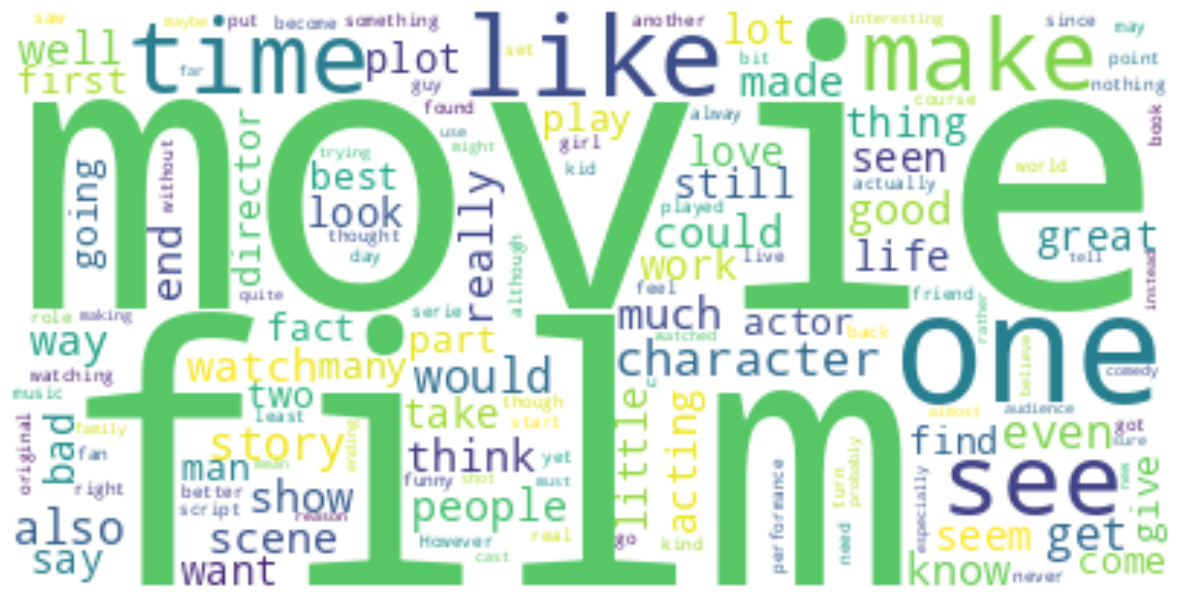

In [39]:
# ... and repeat the wordcloud
display_cloud(df_train['review'])

## Lemmatization
cf. stemming (we're not doing that, for good reasons)
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word.
One major difference with stemming is that lemmatize takes a <b>part of speech parameter, “pos”</b> If not supplied, the default is “noun.”

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
if IN_COLAB:
    nltk.download('tagsets')
    nltk.download('punkt')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [41]:
tagdict = nltk.load('help/tagsets/upenn_tagset.pickle')

def preview_part_of_speech(text: str):
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        words_with_pos: list[tuple[str, str]] = nltk.pos_tag(words)
        for word, pos in words_with_pos:
            print(f'{word :<12}: {pos :<3} - {tagdict[pos][0]}')

preview_part_of_speech("how to use nltk pos tag by using python. it's an interesting topic.")

how         : WRB - Wh-adverb
to          : TO  - "to" as preposition or infinitive marker
use         : VB  - verb, base form
nltk        : JJ  - adjective or numeral, ordinal
pos         : NN  - noun, common, singular or mass
tag         : NN  - noun, common, singular or mass
by          : IN  - preposition or conjunction, subordinating
using       : VBG - verb, present participle or gerund
python      : NN  - noun, common, singular or mass
.           : .   - sentence terminator
it          : PRP - pronoun, personal
's          : VBZ - verb, present tense, 3rd person singular
an          : DT  - determiner
interesting : JJ  - adjective or numeral, ordinal
topic       : NN  - noun, common, singular or mass
.           : .   - sentence terminator


In [42]:
def get_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return ''

In [44]:
lemmatizer=WordNetLemmatizer()

def lemmatize_sentence(sentence: str) -> str:
    words = nltk.word_tokenize(sentence)
    words_with_pos: list[tuple[str, str]] = nltk.pos_tag(words)

    lemmatized_words = []
    for word, pos_tag in words_with_pos:
        wordnet_pos = get_wordnet_pos(pos_tag)
        if wordnet_pos:
            lemmatized_words.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        else:
            lemmatized_words.append(word)

    return ' '.join(lemmatized_words)

def lemmatize_review(review: str) -> str:
    lemmatized_review = ''

    sentences = nltk.sent_tokenize(review)

    lemmatized_sentences = []
    for sentence in sentences:
        lemmatized_sentences.append(lemmatize_sentence(sentence))

    return ' '.join(lemmatized_sentences)


# lemmatize_review("how to use nltk pos tag by using python. it's an interesting topic.")
lemmatize_review(df_train['review'].iloc[10])
# train_df['review']=train_df['review'].apply(lambda z: lemma_traincorpus(z))

"This be my second time through for A Perfect Spy . I watch it 2 or 3 year ago and like it . I like it still . It 's natural that it get compare to the beeb 's other big Le Carre ' series , Tinker Tailor Soldier Spy . Tinker Tailor focus on the `` game '' spy play ; Perfect Spy give us the other axis - what kind of person a spy be . There be a number of theme that these movie share , along with others in the genre . Ambiguity - moral , sexual , interpersonal - which create a multidimensional space of true vs. false , inside vs. outside , love vs. responsibility . In a way , these character be happy when they be be treat the most shabbily by those they love and respect - `` backstabbed '' in its various nuance . The theme of father and father-figure be also important . One of the most intriguing character in A Perfect Spy be Rick , the main character Magnus ' perhaps ersatz father . Throughout the story he betray and be betray . A rogue who always manage to climb back up the ladder when

In [45]:
###########todo lemmative everything

## Load pretrained Embeddings and compute Embedding Coverage

Embedding Coverage tells how much percentage of the words in our data are covered by the vocabulary.

In [46]:
import gensim

In [47]:
# Load pretrained embeddings model (google-news)
#wv = downloader.load('word2vec-google-news-300')  # ~1.7 GB
#wv.save_word2vec_format(BASE_PATH + 'pretrained/word2vec-google-news-300.bin', binary=True)  # >3.5gb; takes some time, esp. on Colab  # see https://code.google.com/archive/p/word2vec/
wv = gensim.models.KeyedVectors.load_word2vec_format(BASE_PATH + 'pretrained/word2vec-google-news-300.bin', binary=True)  # takes a few sec.

In [48]:
def compute_embeddings_coverage(ser: pd.Series):

    # get <<all>> and <<all distinct>> words in train data
    flat_words = [word for review in ser for word in nltk.word_tokenize(review)]
    distinct_words = set(flat_words)
    print(f'Found a total of {len(flat_words) :n} words, with {len(distinct_words) :n} distinct words.')

    missing_words = defaultdict(int)

    for word in flat_words:
        if word not in wv.key_to_index:
            missing_words[word] += 1

    print(f'Found {len(missing_words)} words missing in embeddings.')

    embeddings_vocab_coverage = (len(distinct_words) - len(missing_words)) / len(distinct_words)
    total_words_missing = sum(count for count in missing_words.values())
    embeddings_text_coverage = (len(flat_words) - total_words_missing) / len(flat_words)

    return missing_words, embeddings_vocab_coverage, embeddings_text_coverage

In [49]:
missing_words, embeddings_vocab_coverage, embeddings_text_coverage = compute_embeddings_coverage(ser=df_train['review'])
print(f'Embeddings Vocab Coverage: {embeddings_vocab_coverage :.2%}')
print(f'Embeddings Text Coverage: {embeddings_text_coverage :.2%}')

Found a total of 10,580,291 words, with 161,129 distinct words.
Found 64977 words missing in embeddings.
Embeddings Vocab Coverage: 59.67%
Embeddings Text Coverage: 77.31%


In [50]:
missing_words_list = [(word, count) for word, count in missing_words.items()]
sorted_missing_words = sorted(missing_words_list, key=lambda x: -x[1])
print(f'Most frequently used missing words:')
pprint(sorted_missing_words[:25])

Most frequently used missing words:
[(',', 436123),
 ('.', 432175),
 ('and', 247568),
 ('a', 247230),
 ('of', 227925),
 ('to', 210777),
 ("'s", 62402),
 (')', 57257),
 ('(', 55951),
 ('``', 52993),
 ("''", 52867),
 ('!', 39326),
 ('?', 25999),
 ("'", 16095),
 ('...', 15880),
 (':', 15586),
 ('-', 15356),
 (';', 10610),
 ('--', 8243),
 ('10', 3444),
 ('..', 2795),
 ('wonot', 1914),
 ('Donot', 1713),
 ('20', 1024),
 ('80', 876)]


## More Cleaning

In [51]:
from nltk.tokenize import word_tokenize
import requests

### Remove Stopwords

Most of the most frequent words are considered to be "stopwords". Let's remove them.

In [52]:
# for removing stopwords, we need to tokenize the sentences, before.
# the nltk tokenizers, however, have a huge problem with double quotes:
word_tokenize('More like "dressed-up midgets" than children.')

# we therefore first remove all double quotes (cf. remove punctuation below).
# double_quotes = re.compile(r'"')

def remove_double_quote(review: str):
    #review = double_quotes.sub(r'', review)
    review = review.replace('"', '')
    return review

print(df_train['review'].iloc[5])
ser = df_train['review'].apply(remove_double_quote)
print(ser.iloc[5])

I do miss the company Vestron, they sure had their finger on the pulse of unique and unusual cinema back in the 1980s. This is very apparent with the astonishing Paperhouse, a film that touches me deeply each and every time I watch it. The idea of a girl manipulating a dream world with her drawings (thusly the dream world manipulating reality), and also connecting with and affecting the life of a boy she is never actually met, is fascinating and never disappoints. Charlotte Burke at first seems quite precocious and yet you warm up to her because by being a bit of a mischievous child, it makes it hard for the adults to believe what she is experiencing. She becomes very self aware and strong towards the end, even finding she does not "hate boys" as she so defiantly claimed at first. Through this we are treated to many touching moments and some immensely scary ones, all visually stunning with a grand score from Hans Zimmer. I am quite proud to be an owner of the soundtrack on CD when it w

In [53]:
stop_words = set(nltk.corpus.stopwords.words('english'))
print(f'Loaded {len(stop_words)} NLTK Stopwords')

Loaded 179 NLTK Stopwords


In [54]:
def remove_stopwords(review: str):
    tokenized_review = [word for word in word_tokenize(review) if word.lower() not in stop_words]
    return ' '.join(tokenized_review)

# df_train = df_train.apply(lambda z: remove_url(z))
print('Example before:')
print(ser.iloc[5])

print('\nExample after removing stopwords:')
ser = ser.apply(remove_stopwords)
print(ser.iloc[5])

Example before:
I do miss the company Vestron, they sure had their finger on the pulse of unique and unusual cinema back in the 1980s. This is very apparent with the astonishing Paperhouse, a film that touches me deeply each and every time I watch it. The idea of a girl manipulating a dream world with her drawings (thusly the dream world manipulating reality), and also connecting with and affecting the life of a boy she is never actually met, is fascinating and never disappoints. Charlotte Burke at first seems quite precocious and yet you warm up to her because by being a bit of a mischievous child, it makes it hard for the adults to believe what she is experiencing. She becomes very self aware and strong towards the end, even finding she does not hate boys as she so defiantly claimed at first. Through this we are treated to many touching moments and some immensely scary ones, all visually stunning with a grand score from Hans Zimmer. I am quite proud to be an owner of the soundtrack o

Check embeddings coverage, again

In [55]:
missing_words, embeddings_vocab_coverage, embeddings_text_coverage = compute_embeddings_coverage(ser=ser)
print(f'Embeddings Vocab Coverage: {embeddings_vocab_coverage :.2%}')
print(f'Embeddings Text Coverage: {embeddings_text_coverage :.2%}')

missing_words_list = [(word, count) for word, count in missing_words.items()]
sorted_missing_words = sorted(missing_words_list, key=lambda x: -x[1])
print(f'Most frequently used missing words:')
pprint(sorted_missing_words[:25])

Found a total of 5,962,765 words, with 160,846 distinct words.
Found 65122 words missing in embeddings.
Embeddings Vocab Coverage: 59.51%
Embeddings Text Coverage: 77.16%
Most frequently used missing words:
[(',', 436147),
 ('.', 432580),
 ("'s", 62409),
 (')', 57257),
 ('(', 55951),
 ('!', 39326),
 ('?', 25999),
 ("'", 16096),
 ('...', 15854),
 (':', 15589),
 ('-', 15278),
 (';', 10610),
 ('--', 8243),
 ('10', 3442),
 ('..', 2810),
 ('wonot', 1914),
 ('Donot', 1712),
 ('20', 1024),
 ('80', 875),
 ('30', 785),
 ("'The", 781),
 ('humour', 734),
 ('90', 729),
 ('15', 686),
 ('sci-fi', 672)]


### Remove Punctuation

In [56]:
punct_tag=re.compile(r'[^\w\s]')  # todo str.punc...?

def remove_punctuations(review: str):
    review = punct_tag.sub(r'', review)
    return review

ser = ser.apply(remove_punctuations)

In [57]:
missing_words, embeddings_vocab_coverage, embeddings_text_coverage = compute_embeddings_coverage(ser=ser)
print(f'Embeddings Vocab Coverage: {embeddings_vocab_coverage :.2%}')
print(f'Embeddings Text Coverage: {embeddings_text_coverage :.2%}')

missing_words_list = [(word, count) for word, count in missing_words.items()]
sorted_missing_words = sorted(missing_words_list, key=lambda x: -x[1])
print(f'Most frequently used missing words:')
pprint(sorted_missing_words[:25])

Found a total of 4,801,921 words, with 149,526 distinct words.
Found 51225 words missing in embeddings.
Embeddings Vocab Coverage: 65.74%
Embeddings Text Coverage: 97.43%
Most frequently used missing words:
[('10', 3491),
 ('wonot', 1916),
 ('Donot', 1726),
 ('20', 1062),
 ('80', 938),
 ('30', 822),
 ('12', 812),
 ('90', 757),
 ('15', 755),
 ('humour', 736),
 ('100', 672),
 ('50', 638),
 ('70', 631),
 ('favourite', 478),
 ('40', 477),
 ('80s', 471),
 ('70s', 445),
 ('60', 431),
 ('theatre', 428),
 ('lowbudget', 426),
 ('1010', 420),
 ('810', 343),
 ('710', 332),
 ('13', 328),
 ('11', 318)]


### Remove Numbers

In [58]:
num = re.compile(r'\d+')

def remove_numbers(review: str):
    review = num.sub(r'', review)
    return review

ser = ser.apply(remove_numbers)

In [59]:
missing_words, embeddings_vocab_coverage, embeddings_text_coverage = compute_embeddings_coverage(ser=ser)
print(f'Embeddings Vocab Coverage: {embeddings_vocab_coverage :.2%}')
print(f'Embeddings Text Coverage: {embeddings_text_coverage :.2%}')

missing_words_list = [(word, count) for word, count in missing_words.items()]
sorted_missing_words = sorted(missing_words_list, key=lambda x: -x[1])
print(f'Most frequently used missing words:')
pprint(sorted_missing_words[:25])

Found a total of 4,755,039 words, with 146,270 distinct words.
Found 48162 words missing in embeddings.
Embeddings Vocab Coverage: 67.07%
Embeddings Text Coverage: 98.22%
Most frequently used missing words:
[('wonot', 1916),
 ('Donot', 1726),
 ('humour', 736),
 ('favourite', 478),
 ('theatre', 428),
 ('lowbudget', 426),
 ('overthetop', 306),
 ('Bmovie', 227),
 ('MSTK', 219),
 ('writerdirector', 202),
 ('colour', 190),
 ('realise', 181),
 ('mustsee', 170),
 ('onedimensional', 140),
 ('Canot', 139),
 ('behaviour', 132),
 ('madeforTV', 128),
 ('favour', 128),
 ('thoughtprovoking', 126),
 ('Youhave', 115),
 ('wellwritten', 108),
 ('realised', 105),
 ('programme', 104),
 ('wellmade', 103),
 ('Didnot', 90)]


### Americanize

In [60]:
# A lot of words seem to be british english, let's find the words that would be in the embeddings if we translated 'ou' to 'o'

In [61]:
british_words = [w for w in sorted_missing_words if 'ou' in w[0] and w[0].replace('ou','o') in wv.key_to_index ]
print(british_words[:10])

[('humour', 736), ('favourite', 478), ('colour', 190), ('behaviour', 132), ('favour', 128), ('colours', 86), ('favourites', 69), ('colourful', 48), ('honour', 40), ('neighbours', 39)]


In [62]:
def americanize(review: str):
    tokenized_review = [w.replace('ou', 'o') if (w not in wv.key_to_index
                                                 and 'ou' in w
                                                 and w.replace('ou', 'o') in wv.key_to_index
                                                ) else w for w in word_tokenize(review)]
    return ' '.join(tokenized_review)

ser = ser.apply(americanize)

In [63]:
missing_words, embeddings_vocab_coverage, embeddings_text_coverage = compute_embeddings_coverage(ser=ser)
print(f'Embeddings Vocab Coverage: {embeddings_vocab_coverage :.2%}')
print(f'Embeddings Text Coverage: {embeddings_text_coverage :.2%}')

missing_words_list = [(word, count) for word, count in missing_words.items()]
sorted_missing_words = sorted(missing_words_list, key=lambda x: -x[1])
print(f'Most frequently used missing words:')
pprint(sorted_missing_words[:25])

Found a total of 4,755,039 words, with 146,162 distinct words.
Found 48009 words missing in embeddings.
Embeddings Vocab Coverage: 67.15%
Embeddings Text Coverage: 98.28%
Most frequently used missing words:
[('wonot', 1916),
 ('Donot', 1726),
 ('theatre', 428),
 ('lowbudget', 426),
 ('overthetop', 306),
 ('Bmovie', 227),
 ('MSTK', 219),
 ('writerdirector', 202),
 ('realise', 181),
 ('mustsee', 170),
 ('onedimensional', 140),
 ('Canot', 139),
 ('madeforTV', 128),
 ('thoughtprovoking', 126),
 ('Youhave', 115),
 ('wellwritten', 108),
 ('realised', 105),
 ('programme', 104),
 ('wellmade', 103),
 ('Didnot', 90),
 ('tongueincheek', 88),
 ('Isnot', 88),
 ('centre', 87),
 ('welldone', 87),
 ('wellacted', 86)]


In [64]:
# let's try to americanize with a static translation json
dl_url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american_map = requests.get(dl_url).json()
len(british_to_american_map)
print(british_to_american_map['colour'])

color


In [65]:
def americanize_pt2(review: str):
    tokenized_review = [british_to_american_map[w] if w in british_to_american_map
                        else w for w in word_tokenize(review)]
    return ' '.join(tokenized_review)

ser = ser.apply(americanize_pt2)

In [66]:
missing_words, embeddings_vocab_coverage, embeddings_text_coverage = compute_embeddings_coverage(ser=ser)
print(f'Embeddings Vocab Coverage: {embeddings_vocab_coverage :.2%}')
print(f'Embeddings Text Coverage: {embeddings_text_coverage :.2%}')

missing_words_list = [(word, count) for word, count in missing_words.items()]
sorted_missing_words = sorted(missing_words_list, key=lambda x: -x[1])
print(f'Most frequently used missing words:')
pprint(sorted_missing_words[:25])

Found a total of 4,755,039 words, with 145,742 distinct words.
Found 47670 words missing in embeddings.
Embeddings Vocab Coverage: 67.29%
Embeddings Text Coverage: 98.34%
Most frequently used missing words:
[('wonot', 1916),
 ('Donot', 1726),
 ('lowbudget', 426),
 ('overthetop', 306),
 ('Bmovie', 227),
 ('MSTK', 219),
 ('writerdirector', 202),
 ('mustsee', 170),
 ('onedimensional', 140),
 ('Canot', 139),
 ('madeforTV', 128),
 ('thoughtprovoking', 126),
 ('Youhave', 115),
 ('wellwritten', 108),
 ('wellmade', 103),
 ('Didnot', 90),
 ('tongueincheek', 88),
 ('Isnot', 88),
 ('welldone', 87),
 ('wellacted', 86),
 ('soso', 86),
 ('firstrate', 82),
 ('selfindulgent', 79),
 ('didnt', 73),
 ('Bmovies', 73)]


## Prepare data for NN Model

In [67]:
import pickle

### Create Vocabulary and embeddings

In [68]:
VOCAB_SIZE = 80000

In [69]:
# we won't encode all words, but only the 80.000 most common words
flat_words = [word for review in ser for word in word_tokenize(review)]
distinct_words = set(flat_words)
print(f'{len(distinct_words)} distinct words.')

145742 distinct words.


In [70]:
counter = Counter(flat_words)
counts_most_common = counter.most_common(VOCAB_SIZE)
most_common_words = [w[0] for w in counts_most_common]
print(counts_most_common[:20])

[('movie', 68443), ('s', 65420), ('film', 61915), ('one', 38151), ('like', 30079), ('would', 22497), ('good', 22243), ('time', 18789), ('really', 17919), ('story', 17663), ('see', 17466), ('even', 17393), ('much', 14885), ('could', 14671), ('get', 14379), ('people', 13721), ('bad', 13627), ('great', 13339), ('well', 13110), ('made', 12336)]


In [71]:
# word to index
words_with_embeddings = [w for w in most_common_words if w in wv.key_to_index]
print(f'{len(words_with_embeddings)} words with pretrained word vectors.')

69261 words with pretrained word vectors.


In [72]:
words_without_embeddings = [w for w in most_common_words if w not in wv.key_to_index]
print(f'{len(words_without_embeddings)} words without pretrained word vectors.')

10739 words without pretrained word vectors.


In [73]:
indices = [wv.key_to_index[w] for w in words_with_embeddings]
print(max(indices))

2992758


In [74]:
token_to_index = {token: index for index, token in enumerate(words_with_embeddings+words_without_embeddings)}
index_to_token = {index: token for token, index in token_to_index.items()}

# wrapper for token-to-index mapping
vocab = torchtext.vocab.vocab(token_to_index)

In [75]:
# Create initiual embeddings with all-zeros for our 80.000 words with 300 dimensions (like pretrained embeddings)
embeddings = torch.zeros(VOCAB_SIZE, wv.vectors.shape[1])
embeddings.shape

torch.Size([80000, 300])

In [76]:
# we use the known words' embeddings in our model
indices_with_embeddings = [token_to_index[w] for w in words_with_embeddings]

index_to_pretrained_index = {index: wv.key_to_index[index_to_token[index]] for index in indices_with_embeddings}

for index, pretrained_index in index_to_pretrained_index.items():
    embeddings[index] = torch.Tensor(wv.vectors[pretrained_index])  # ndarray to tensor

### Save everything

In [77]:
torch.save(embeddings, BASE_PATH + 'saves/embeddings_imdb.pt')
torch.save(vocab, BASE_PATH + 'saves/vocab_imdb.pt')

In [78]:
df_train['review'] = ser

with open(BASE_PATH + 'saves/df_train_imdb.pickle', 'wb') as file:
    pickle.dump(df_train, file)

In [79]:
# load:
import torch
import torch.nn as nn
import pickle
import pandas as pd
from nltk.tokenize import word_tokenize

embeddings = torch.load(BASE_PATH + 'saves/embeddings_imdb.pt')
vocab = torch.load(BASE_PATH + 'saves/vocab_imdb.pt')

with open(BASE_PATH + 'saves/df_train_imdb.pickle', 'rb') as file:
    df_train = pickle.load(file)


token_to_index = {token: index for index, token in enumerate(vocab.get_itos())}

### Tokenize

In [80]:
def tokenize_(review: str) -> str:
    tokenized_review = [w for w in word_tokenize(review) if w in vocab]
    return tokenized_review

tokenized_reviews = df_train['review'].apply(tokenize_)

In [81]:
print(f'tokenized_review is a {type(tokenized_reviews)} of shape {tokenized_reviews.shape}')
print(f'Example review: {tokenized_reviews[500]}')

tokenized_review is a <class 'pandas.core.series.Series'> of shape (40000,)
Example review: ['empty', 'lack', 'luster', 'rendition', 'classic', 'novel', 'wish', 'people', 'would', 'stop', 'messing', 'classics', 'clearly', 'idea', 'real', 'intention', 'point', 'original', 'version', 'different', 'felt', 'Ralph', 'Fiennes', 'version', 'much', 'worse', 'though', 'casting', 'Juliette', 'brioche', 'Kathy', 'got', 'worst', 'casting', 'decision', 'EVER', 'anyway', 'back', 'version', 'aims', 'make', 'story', 'relevant', 'contemporary', 'setting', 'musical', 'style', 'succeeds', 'high', 'art', 'nit', 'viewing', 'rainy', 'day', 'maybe', 'direction', 'average', 'editing', 'abysmal', 'Worse', 'old', 'Quincy', 'Deepak', 'Verma', 'great', 'turn', 'Hindley', 'fact', 'one', 'Britains', 'wasted', 'talents', 'part', 'Heath', 'played', 'great', 'charm', 'belief', 'think', 'casting', 'strongest', 'point', 'project', 'Although', 'talented', 'director', 'would', 'made', 'better', 'use', 'facilities', 'clear

### Tensorize / Token to Index

In [82]:
# indexed_reviews = tokenized_reviews.apply(vocab)  # doesn't work in notebook

def tensorize_review(tokenized_review: list[str]) -> torch.Tensor:
    indices = [token_to_index[w] for w in tokenized_review]
    return torch.tensor(indices, dtype=torch.long)

tensor = tensorize_review(tokenized_reviews[500])
print(f'Example: {tensor}')
print(tensor.shape)

Example: tensor([ 1845,   407, 22514,  4235,   233,   500,   509,    14,     4,   480,
        11126,  2053,   561,   183,    54,  3184,   109,    87,   187,   146,
          288,  3007,  7018,   187,    11,   306,    64,   909,  6216, 61847,
         5269,    76,   132,   909,  1896,  2928,   713,    51,   187,  9198,
           22,     8,  3126,  2087,   742,   540,   298,  2642,   229,   413,
        27386,   611,  6539,   176,   252,   341,   707,   622,  4257,  6159,
           66, 16163, 55311, 17304,    16,   338, 52152,    81,     2, 40407,
          786,  1757,    67,  8679,   131,    16,  1252,  2388,    25,   909,
         5410,   109,  1097,   447,   856,    71,     4,    18,    42,   210,
        17123,   569,    71,  3849, 19002,  1097,  1501,  1708])
torch.Size([98])


## Model

In [83]:
from sklearn import preprocessing

In [84]:
class Classifier(nn.Module):
    def __init__(self, embedding_matrix):
        """
        Given embedding_matrix: numpy array with vector for all words
        return prediction ( in torch tensor format)
        """
        super(Classifier, self).__init__()
        # Dimension of embedding is num of columns in the matrix
        embedding_dim = embedding_matrix.shape[1]
        # Define an input embedding layer
        self.embedding = nn.Embedding(num_embeddings=embedding_matrix.shape[0],  # number of words
                                      embedding_dim=embedding_dim)
        # Embedding matrix actually is collection of parameter
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,
                                                          dtype = torch.float32))
        # Because we use pretrained embedding (GLove, Fastext,etc) so we turn off requires_grad-meaning we do not train gradient on embedding weight
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(
                            input_size=embedding_dim,
                            hidden_size=128,
                            bidirectional=True,
                            batch_first=True,
                             )
        # Input(512) because we use bi-directional LSTM ==> hidden_size*2 + maxpooling **2  = 128*4 = 512, will be explained more on forward method
        # self.out = nn.Linear(512, 1)
        self.out = nn.Linear(in_features=512,
                             out_features=2)
        # new
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):  # x: [1, ~231]
        # pass input (tokens) through embedding layer
        x = self.embedding(x)  # [1, ~231, 300]
        # fit embedding to LSTM
        hidden, _ = self.lstm(x)  # hidden: [1, ~231, 256]
        # apply mean and max pooling on lstm output
        avg_pool= torch.mean(hidden, 1)  # [1, 256]
        max_pool, index_max_pool = torch.max(hidden, 1)  # [1, 256], [1, 256]
        # concat avg_pool and max_pool ( so we have 256 size, also because this is bidirectional ==> 256*2 = 512)
        out = torch.cat((avg_pool, max_pool), 1)  # [1, 512]
        # fit out to self.out to conduct dimensionality reduction from 512 to 1
        out = self.out(out)  # [1, 2]
        # new: just normalize to sum of 1
        out = self.softmax(out)  # [1, 2]
        return out

In [85]:
model = Classifier(embedding_matrix=embeddings).to(DEVICE)

<ipython-input-84-06fee15f7ed2>:14: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



### Training

In [86]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [87]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df_train['sentiment'])
labels = label_encoder.transform(df_train['sentiment'])
print(labels)

[0 1 1 ... 0 1 0]


In [92]:
PRINT_LOSS_EVERY_N_TOKENS = 3000
N_EPOCHS = 5

recent_losses = []
for epoch in range(N_EPOCHS):

    # x_batch: [{batch_size}, 4]
    # y_batch: [{batch_size}]
    for review_num in range(len(tokenized_reviews)):


        optimizer.zero_grad()

        x = tensorize_review(tokenized_reviews.iloc[review_num]).unsqueeze(dim=0).to(DEVICE)  # [1, ~164]
        label = labels[review_num]
        target = torch.tensor(label).type(torch.long).unsqueeze(dim=0).to(DEVICE)  # [1]

        log_probs = model(x)

        current_loss = loss_function(log_probs,
                                     target)

        current_loss.backward()
        optimizer.step()

        recent_losses.append(current_loss.item())

        if review_num % PRINT_LOSS_EVERY_N_TOKENS == 0:
            print(sum(recent_losses)/len(recent_losses))
            recent_losses = []

        # steps_done += len(x_batch)

0.6612420678138733
0.6350376302103201
0.5432473799188932
0.506452476332585
0.49567136309544246
0.4962288493315379
0.47798343179623287
0.47084998661279676
0.4734322309195995


KeyboardInterrupt: ignored

In [93]:
torch.save(model.state_dict(), BASE_PATH + '/saves/imdb_sentiment_w_pretr_emb.pt')

In [94]:
model = Classifier(embedding_matrix=embeddings).to(DEVICE)
model.load_state_dict(torch.load(BASE_PATH + '/saves/imdb_sentiment_w_pretr_emb.pt',
                                 map_location=torch.device(DEVICE)))

<ipython-input-84-06fee15f7ed2>:14: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



<All keys matched successfully>

### Sample Predictions

#### Train

In [95]:
def predict(model: Classifier, review: str):
    tokenized_review: list[str] = tokenize_(review)
    x = tensorize_review(tokenized_review).unsqueeze(dim=0).to(DEVICE)  # [1, ~164]

    log_probs = model(x)
    return log_probs

results: list[bool] = []
model.eval()
with torch.no_grad():
    for i in range(len(df_train)):
        ser_imdb = df_train.iloc[i]
        log_probs = predict(model=model,
                            review=ser_imdb['review'])
        predicted_label = torch.argmax(log_probs).item()
        predicted_sentiment = predicted_sentiment = label_encoder.inverse_transform([predicted_label])[0]
        results.append(True if predicted_sentiment == ser_imdb["sentiment"] else False)

        #confidence = log_probs.max().item()
        #print(f'Review: {ser_imdb["review"][:125]}')
        #print(f'Target Sentiment: {ser_imdb["sentiment"]}')
        #print(f'Predicted Sentiment: {predicted_sentiment}. Confidence: {confidence :.0%}\n')

print(f'Correct predictions: {sum(results)}/{len(results)} (-> Accuracy = {sum(results) / len(results) :.2%})')

Correct predictions: 34391/40000 (-> Accuracy = 85.98%)


#### Test

In [106]:
# apply the same preprocessing steps to test data
cleansed = (df_test['review'].apply(remove_html)
                             .apply(remove_duplice_whitespace)
                             .apply(remove_url)
                             .apply(replace_contraction)

                             .apply(remove_double_quote)
                             .apply(remove_stopwords)
                             .apply(remove_punctuations)
                             .apply(remove_numbers)

                             .apply(americanize)
                             .apply(americanize_pt2)
                             )

In [108]:
df_test['review'] = cleansed

In [109]:
# evaluate
results: list[bool] = []
model.eval()
with torch.no_grad():
    for i in range(len(df_test)):
        ser_imdb = df_test.iloc[i]
        log_probs = predict(model=model,
                            review=ser_imdb['review'])
        predicted_label = torch.argmax(log_probs).item()
        predicted_sentiment = predicted_sentiment = label_encoder.inverse_transform([predicted_label])[0]
        results.append(True if predicted_sentiment == ser_imdb["sentiment"] else False)

        #confidence = log_probs.max().item()
        #print(f'Review: {ser_imdb["review"][:125]}')
        #print(f'Target Sentiment: {ser_imdb["sentiment"]}')
        #print(f'Predicted Sentiment: {predicted_sentiment}. Confidence: {confidence :.0%}\n')

print(f'Correct predictions: {sum(results)}/{len(results)} (-> Accuracy = {sum(results) / len(results) :.2%})')

Correct predictions: 8378/10000 (-> Accuracy = 83.78%)


## Backup

In [ ]:
print(4/6)

In [ ]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }


In [ ]:
pprint(punct_mapping)

In [ ]:
specials_mapping = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last


In [ ]:
pprint(specials_mapping)

In [ ]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    for word in vocab.keys():
        if word in embeddings_index:
            known_words[word] = vocab[word]
            continue
        unknown_words[word] = vocab[word]

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    num_known_words = np.sum(np.asarray(list(known_words.values())))
    num_unknown_words = np.sum(np.asarray(list(unknown_words.values())))
    print('Found embeddings for  {:.3%} of all text'.format(float(num_known_words) / (num_known_words + num_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

Map The Rest OOV Tokens to "[ name ]"

In [ ]:
def map_unknown_token(text, dst_token, unknown_vocab_set):
#     token_list = []
#     for t in text.split(" "):
#         if t in unknown_vocab_set:
#             token_list.append(dst_token)
#         else:
#             token_list.append(t)

#     return " ".join(token_list)
    return' '.join([dst_token if t.lower() in unknown_vocab_set else t for t in text.split(" ")])

In [ ]:
unknown_vocab_set = set(list(map(
    lambda unknown_vocab_tuple: unknown_vocab_tuple[0],
    unknown_vocab
)))
train_df.loc[:, 'Phrase'] = train_df['Phrase'].map(lambda ele: map_unknown_token(ele, "[ name ]", unknown_vocab_set))
test_df.loc[:, 'Phrase'] = test_df['Phrase'].map(lambda ele: map_unknown_token(ele, "[ name ]", unknown_vocab_set))

Build embedding matrix

In [ ]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = None
    if word in w2v:
        embedding_vector = w2v[word]
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

del w2v
gc.collect()

Encode labels

In [ ]:
from sklearn import preprocessing

In [ ]:
y_train = train_df['Sentiment']

led = preprocessing.LabelEncoder()
led.fit(y_train.values)

y_train = led.transform(y_train.values)